# Importing Necessary Libraries

In [14]:
import numpy as np
import cv2
from ultralytics import YOLO

from court_line_detector import CourtLineDetector
from utils import *

import warnings
warnings.filterwarnings('ignore')

# Reading Video by Frame and Importing the Models

A sample frame of the video is shown below



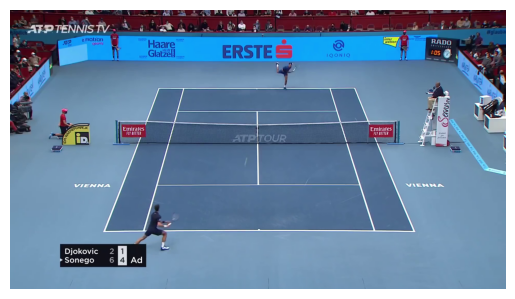

In [15]:
court_extractor_model = CourtLineDetector(r"models/keypoints_model.pth")
ball_tracking_model = YOLO(r'models/best.pt')
video_name = r"input_video_1.mp4"
video_frames = read_video(r"input_videos/" + video_name)

print("A sample frame of the video is shown below\n")
plot_cv2_img_using_matplotlib(video_frames[0])

# Cropping Out the Court from each frame 

In [16]:
output_frames = []

for frame in video_frames[:10]:

    # Predicting Four Corner Points of the Court
    corners = court_extractor_model.predict(frame)[:8].reshape((-1, 2))

    A, B, C, D = corners[0], corners[1], corners[3], corners[2]
    AB = np.linalg.norm(B - A) * 0.2
    DA = np.linalg.norm(D - A) * 0.2
    BC = np.linalg.norm(C - B) * 0.2
    CD = np.linalg.norm(D - C) * 0.2

    A = np.float32([A[0] - AB, A[1] - DA])
    B = np.float32([B[0] + AB, B[1] - BC])
    C = np.float32([C[0] + CD, C[1] + BC])
    D = np.float32([D[0] - CD, D[1] + DA])

    corner_points = np.float32([A, B, C, D])

    # Dimension of output image and their Destination
    width, height = (500, 750)
    destination_points = np.float32([
        [0, 0],                 # top-left corner of the output
        [width-1, 0],           # top-right corner of the output
        [width-1, height-1],    # bottom-right corner of the output
        [0, height-1]           # bottom-left corner of the output
    ])
    
    # Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(corner_points, destination_points)

    # Applying the Transformation
    transformed_image = cv2.warpPerspective(frame, M, (width, height))
    output_frames.append(transformed_image)

Sample Input Image



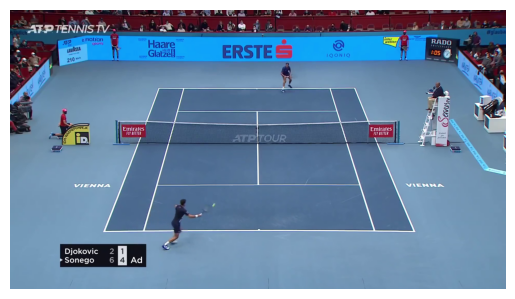

In [17]:
print("Sample Input Image\n")
plot_cv2_img_using_matplotlib(frame)

Sample Transformed Image



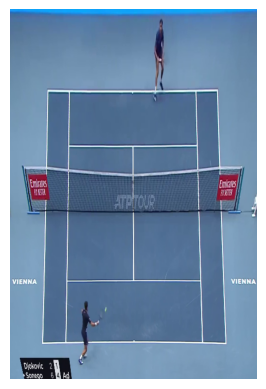

In [18]:
print("Sample Transformed Image\n")
plot_cv2_img_using_matplotlib(transformed_image)

# Ball Tracking

In [19]:
# Empty list for storing output frames
output_video_frames = []
ratio_corrector = video_frames[0].shape[1] / video_frames[0].shape[0]
x1, y1, x2, y2 = (0, 0, 0, 0)
prev_center = (0, 0)
speed = 0
speed_history = []
rolling_window = 10
#Looping through each frame from model output
for i in range(len(output_frames)):

    # Getting ball positions from the model
    result = ball_tracking_model.predict(output_frames[i], conf=0.2, save=False)
    
    # Importing an image of a court and Resizing it
    court_image = cv2.imread("tennis_court.jpg")
    court_image = cv2.resize(court_image, (width, height))

    # Plotting in the Court if there is any detection and calculating the speed
    if result[0].boxes.shape[0] != 0:
        best_idx = np.argmax(result[0].boxes.conf.cpu().numpy())
        x1, y1, x2, y2 = map(int, result[best_idx].boxes.xyxy[0])
        current_center = (((x1 + x2)) // 2, ((y1 + y2)) // 2)
        speed = np.linalg.norm(np.array(current_center) - np.array(prev_center)) * 6.8
        speed_history.append(max(min(130, speed),60))
        if len(speed_history) > rolling_window:
            speed_history.pop(0)
        speed = sum(speed_history) / len(speed_history)
        print(speed_history, speed)
        
        prev_center = current_center

    cv2.rectangle(court_image, (x1, y1), (x2, y2), (0, 0, 255), 6)
    cv2.putText(court_image, f"Speed: {speed:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # Original frame to be concatenated
    original_frame = cv2.resize(video_frames[i], (int(height*ratio_corrector), height))

    # Making of output video frame
    current_frame = cv2.hconcat([court_image, original_frame])
    output_video_frames.append(current_frame)

    # Showing the generated frames
    cv2.imshow("Output Frame", current_frame)
    cv2.waitKey(300)
    cv2.destroyAllWindows()

# Saving Output Video
save_video(output_video_frames, 'output_for_' + video_name)


0: 640x448 (no detections), 17.8ms
Speed: 4.0ms preprocess, 17.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 tennis balls, 5.0ms
Speed: 5.4ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)
[130] 130.0

0: 640x448 2 tennis balls, 5.8ms
Speed: 9.9ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)
[130, 92.48999945940102] 111.24499972970051

0: 640x448 2 tennis balls, 22.2ms
Speed: 8.8ms preprocess, 22.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 448)
[130, 92.48999945940102, 68.0] 96.82999981980034

0: 640x448 1 tennis ball, 11.2ms
Speed: 12.9ms preprocess, 11.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)
[130, 92.48999945940102, 68.0, 60] 87.62249986485025

0: 640x448 1 tennis ball, 87.0ms
Speed: 0.4ms preprocess, 87.0ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 448)
[130, 92.48999945940102, 68.0, 60, 94.71304028485201]

Sample Output Frame



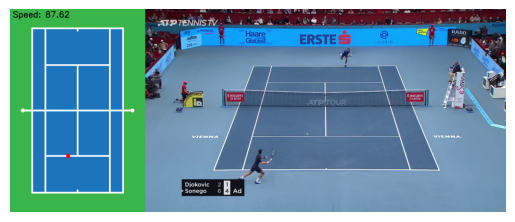

In [20]:
print("Sample Output Frame\n")
plot_cv2_img_using_matplotlib(output_video_frames[4])